## Travel Insurance model predictor
In this notebook, I display factors that affect travel insurance purchase and perform machine learning methods to create models that predict the purchase of it.
The goals are to:
- Direct marketing campaign to specific targets;
- Cost reduction;
- Profit increase.

So, lets begin!

#### Importing Libraries

In [1]:
# Helpers libraries
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np

# Machine learning libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

#### Data

The data can be found here: https://raw.githubusercontent.com/amankharwal/Website-data/master/TravelInsurancePrediction.csv

In [2]:
df = pd.read_csv("TravelInsurancePrediction.csv")
df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Lets drop the first column, since it is only for enumerating the data, something that pandas already does.

In [3]:
df.drop(columns=["Unnamed: 0"], inplace = True)

And lets check for missing values.

In [4]:
df.isnull().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

No null data. If there was missing data, we would need to fill it (with our preference method to do so).

#### Displaying some factors that affect travel insurance purchase

The goal here would be to find the factors that most affect the decision of whether to buy or not. This could be a indicative for the marketing team to direct campaigns to different target.

First, we will just map the binary information in the columns "TravelInsurance" to display "Not purchased" (corresponding to 0) and "Purchased" (corresponding to 1) for a better visualization.

In [5]:
df["TravelInsurance"] = df["TravelInsurance"].map({0: "Not purchased", 1: "Purchased"})

fig = px.histogram(df, x = "Age",
                   color = "TravelInsurance",
                   title = "Factors that affect travel insurance purchased: Age")
fig.show()

In [6]:
figure = px.histogram(df, x = "Employment Type", 
                      color = "TravelInsurance", 
                      title= "Factors that affect travel insurance purchased: Employment Type")
figure.show()

In [7]:
figure = px.histogram(df, x = "AnnualIncome", 
                      color = "TravelInsurance", 
                      title= "Factors that affect travel insurance purchased: Income")
figure.show()

In [8]:
figure = px.histogram(df, x = "GraduateOrNot", 
                      color = "TravelInsurance", 
                      title= "Factors that affect travel insurance purchased: GraduateOrNot")
figure.show()

*I.e.*, people at the age of 34 are more frequent buyers. The same for people that work in private sectors, have a annual income of 1.4M and are graduated. Now, we can contact the marketing team and present them this data, and they could direct our campaigns for the non-buyers to try to reach them based on this.

#### Data Preprocessing 

Now, lets start working with our data to build our machine learning model. We will also perform some statistics test to check valid variables to the model, and to validate what we said previously.

In [9]:
df["Employment Type"] = df["Employment Type"].map({"Government Sector": 0, "Private Sector/Self Employed": 1}) # redo the mapping
df["GraduateOrNot"] = df["GraduateOrNot"].map({"No": 0, "Yes": 1})                                             # mapping to binary
df["FrequentFlyer"] = df["FrequentFlyer"].map({"No": 0, "Yes": 1})                                             # mapping to binary
df["EverTravelledAbroad"] = df["EverTravelledAbroad"].map({"No": 0, "Yes": 1})                                 # mapping to binary
df["TravelInsurance"] = df["TravelInsurance"].map({"Not purchased": 0, "Purchased": 1})                        # mapping to binary

And here is what our data set look now

In [10]:
df

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,0,1,400000,6,1,0,0,0
1,31,1,1,1250000,7,0,0,0,0
2,34,1,1,500000,4,1,0,0,1
3,28,1,1,700000,3,1,0,0,0
4,28,1,1,700000,8,1,1,0,0
...,...,...,...,...,...,...,...,...,...
1982,33,1,1,1500000,4,0,1,1,1
1983,28,1,1,1750000,5,1,0,1,0
1984,28,1,1,1150000,6,1,0,0,0
1985,34,1,1,1000000,6,0,1,1,1


Before we continue, you can see that AnnualIncome has much larger values than all of the data, and that coud gives a biased model. So, we need to scale it, and Age and FamilyMembers too! (but separately).

Lets starts by spliting our data and then apply the StandardScaler object.

In [11]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [13]:
sc = StandardScaler()
x_train[["Age", "AnnualIncome", "FamilyMembers"]]= sc.fit_transform(x_train[["Age", "AnnualIncome", "FamilyMembers"]])
x_test[["Age", "AnnualIncome", "FamilyMembers"]] = sc.transform(x_test[["Age", "AnnualIncome", "FamilyMembers"]])



Okay! Things are scaled up properly. Now, lets check some statistics: we want to see if there is no high correlation between variables (that is, if one variable can predict the other, and the latter would not be necessary for the model)

<AxesSubplot:>

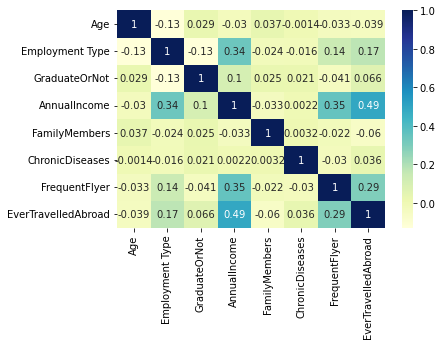

In [15]:
sns.heatmap(x_train.corr(), annot=True, cmap="YlGnBu")


We can see that AnnualIncome has high correlation with TRavelInsurance, and that is good. But is it to good? Lets check the VIF (variance Inflation Factor), that gives the colinearity between variables (if one can predict the other).

In [16]:
vif = pd.DataFrame()
vif["features"] = x_train.columns
vif["vif_Factor"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
print(vif)

              features  vif_Factor
0                  Age    1.015008
1      Employment Type    2.638818
2        GraduateOrNot    2.743494
3         AnnualIncome    1.368986
4        FamilyMembers    1.005602
5      ChronicDiseases    1.348218
6        FrequentFlyer    1.437851
7  EverTravelledAbroad    1.654243


High values indicates that these variables can be predicted by others, but we do not see much high values here (maximum is 2.7!). I should emphasize that the VIF is for linear regression methods, but it serves as an example of usage of VIF. Higher values (> 10) would indicate for us the independent variables that can be droped from the model.

#### Model construction

Now the machine learning begins! We will perform, initially, a DecisionTreeClassifier, a good choice for classification, and see how it performs.

Lets just adjust our data first.

In [17]:
x_train = x_train.values
x_test = x_test.values

In [18]:
y_train

array([1, 0, 1, ..., 0, 1, 0])

#### Decision Tree Classifier

In [19]:
model = DecisionTreeClassifier()

model.fit(x_train, y_train)
y_pred = model.predict(x_test)


cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[229  28]
 [ 48  93]]


0.8090452261306532

The model have 228 True positives, 49 False positives, 29 False negatives and 92 True negatives, and an accuracy of $\sim 80 \%$, which is generally good. 

#### Predicting if a client buyes the travel insurance

Client:
- Age: 30;
- Employment type: 0 (Govern Sector);
- Graduate or Not: 1 (yes);
- Annual Income: 200000;
- Family Members: 3;
- Chronic diseases: ; 0 (no);
- Frequent Flier: 1 (yes);
- Ever Travelled abroad: 1 (yes).

But remember: we have to scale the data!

In [20]:
x_val_pred = sc.transform([[30,200000,3]])
if model.predict(([[x_val_pred[0][0], 0, 1, x_val_pred[0][1], x_val_pred[0][2], 0, 1, 1]])) == 0:
    print("The client does not buy the insurance")
else:
    print("The client buyes the insurance")


The client does not buy the insurance


/home/depaula/anaconda3/envs/jupyter-pyroot/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



So, great! We have our model. We can now create more models, based on different methodos and check which one is the best for this case.

#### Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[229  28]
 [ 48  93]]


0.8090452261306532

#### Naive Bayes Classifier

In [22]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[220  37]
 [ 68  73]]


0.7361809045226131

#### Kernel Support Vector Machine Classifier

In [23]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[245  12]
 [ 63  78]]


0.8115577889447236

#### K-Neighbors Classifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)  
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[232  25]
 [ 59  82]]


0.7889447236180904

#### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[236  21]
 [ 71  70]]


0.7688442211055276

And with those, we have our models. We can see that the best options would be the Decision Tree, the Random Forest and the Kernel Support Vector Machine.